In [1]:
import os
import glob
import re
from datetime import datetime
import pyart
import numpy as np
import xarray as xr
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

_ts_pattern = re.compile(r"(\d{2}[A-Z]{3}\d{4}_\d{6})")
def _parse_ts(fp: str) -> datetime:
    name = os.path.basename(fp).split(".")[0]
    m = _ts_pattern.search(name)
    if not m:
        raise ValueError(f"Filename `{name}` missing timestamp")
    return datetime.strptime(m.group(1), "%d%b%Y_%H%M%S")

def extract_start_time(f):
    arr = xr.open_dataset(f, decode_times=False)['time_coverage_start'].values[:17]
    s = b''.join(arr).decode("utf-8").rstrip("Z")
    return datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")

def convert_radartoxarray(f):
    z_lim, y_lim, x_lim = (0.,20000.),(-240500.,240500.),(-240500.,240500.)
    res_h, res_v = 1000, 245
    def npts(lim, res): return int((lim[1]-lim[0])/res)
    shape = (npts(z_lim, res_v), npts(y_lim, res_h), npts(x_lim, res_h))
    radar = pyart.io.read(f)
    radar.time['units'] = f"seconds since {extract_start_time(f)}"
    grid = pyart.map.grid_from_radars(
        radar, grid_shape=shape, grid_limits=(z_lim, y_lim, x_lim)
    )
    return grid.to_xarray()

def build_mask(ds, time_idx=0, height_idx=8):
    return ds['DBZ'][time_idx, height_idx].values > 0

def preprocess_dbz(arr, mask, min_val=0.0, max_val=70.0):
    arr = np.where(mask, np.nan, arr) 
    arr[np.isnan(arr)] = min_val 
    arr = np.clip(arr, min_val, max_val)
    arr = (arr - min_val) / (max_val - min_val) #normalize to [0, 1]
    #also norming to [-1, 1]
    arr = arr * 2 - 1
    return arr

# def get_mean_std(all_files, mask):
#     if os.path.exists("mean_std.npz"):
#         data = np.load("mean_std.npz")
#         return data["mean"], data["std"]
#     cube = []
#     for f in tqdm(all_files, desc="Loading data for stats"):
#         arr = xr.open_dataset(f)["DBZ"].isel(time=0).values.astype(np.float32)
#         arr = np.where(mask, np.nan, arr)
#         arr[np.isnan(arr)] = 0
#         cube.append(arr)
#     cube = np.stack(cube, 0)
#     mean, std = cube.mean(0), cube.std(0)
#     np.savez("mean_std.npz", mean = mean, std = std)
#     return mean, std

class RadarNowcastDataset(Dataset):
    def __init__(self, files, window, mask):
        self.files = sorted(files, key=_parse_ts)
        self.window = window
        self.mask = mask
        assert len(self.files) > window
        ds = xr.open_dataset(self.files[0])
        self.lat = ds['lat']
        self.lon = ds['lon']
        self.lat = torch.from_numpy(self.lat.values)
        self.lon = torch.from_numpy(self.lon.values)

    def __len__(self):
        return len(self.files) - self.window

    def __getitem__(self, i):
        seq = self.files[i : i + self.window + 1]
        frames = []
        for f in seq:
            arr = xr.open_dataset(f)["DBZ"].isel(time=0).values.astype(np.float32)
            frames.append(preprocess_dbz(arr, self.mask))
        stk = np.stack(frames, 0)
        x = torch.from_numpy(stk[:self.window])
        y = torch.from_numpy(stk[self.window:])

        _, H, W = x.shape
        factor = 2**6
        ph = (factor - H % factor) % factor
        pw = (factor - W % factor) % factor
        pad = (pw//2, pw - pw//2, ph//2, ph - ph//2)
        
        return {
            'input': F.pad(x, pad),
            'target': F.pad(y, pad),
            'lat': self.lat,
            'lon': self.lon,
        }

def plot_sample(sample, vmin=0, vmax=70, label1="Last Input Frame", label2="Target Frame"):
    x = sample['input'][-1].numpy()
    y = sample['target'][0].numpy()
    lat = sample['lat'].numpy()
    lon = sample['lon'].numpy()
    H, W = lat.shape
    pad_h = x.shape[0] - H
    pad_w = x.shape[1] - W
    
    top = pad_h // 2
    left = pad_w // 2
    x_cropped = x[top:top+H, left:left+W]
    y_cropped = y[top:top+H, left:left+W]

    x_cropped = (x_cropped + 1.0) / 2.0
    y_cropped = (y_cropped + 1.0) / 2.0
 
    x_cropped[x_cropped <= 0] = np.nan
    y_cropped[y_cropped <= 0] = np.nan

    x_cropped = x_cropped * (70)
    y_cropped = y_cropped * (70)
    plt.figure(figsize=(16, 6))
    
    plt.subplot(121)
    plt.pcolormesh(lon, lat, x_cropped, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(label="Reflectivity (dBZ)")
    plt.title(label1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.subplot(122)
    plt.pcolormesh(lon, lat, y_cropped, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(label="Reflectivity (dBZ)")
    plt.title(label2)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.tight_layout()
    plt.show()


def plot_dbz_raw(sample, vmin=0, vmax=70):
    x = sample['input'][-1].numpy()
    y = sample['target'][0].numpy()
    
    H, W = 481, 481
    pad_h = x.shape[0] - H
    pad_w = x.shape[1] - W
    top = pad_h // 2
    left = pad_w // 2
    
    x_cropped = x[top:top+H, left:left+W]
    y_cropped = y[top:top+H, left:left+W]
    
    x_cropped = (x_cropped + 1.0) / 2.0
    y_cropped = (y_cropped + 1.0) / 2.0

    x_cropped[x_cropped <= 0] = np.nan
    y_cropped[y_cropped <= 0] = np.nan

    x_cropped = x_cropped * (70)
    y_cropped = y_cropped * (70)
    
    plt.figure(figsize=(16, 6))

    plt.subplot(121)
    plt.imshow(x_cropped, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(label="Reflectivity (dBZ)")
    plt.title("Last Input Frame")
    plt.xlabel("X Pixel")
    plt.ylabel("Y Pixel")

    plt.subplot(122)
    plt.imshow(y_cropped, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(label="Reflectivity (dBZ)")
    plt.title("Target Frame")
    plt.xlabel("X Pixel")
    plt.ylabel("Y Pixel")

    plt.tight_layout()
    plt.show()


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [10]:
data_dir = "full_dataset"
ref_file = "RCTLS_05AUG2020_161736_L2B_STD.nc"

ds_ref = convert_radartoxarray(ref_file)
mask = build_mask(ds_ref)

all_files = glob.glob(os.path.join(data_dir, "*.nc"))

window_size = 4
batch_size = 8

dataset = RadarNowcastDataset(
    files=all_files,
    window=window_size,
    mask=mask,
    )

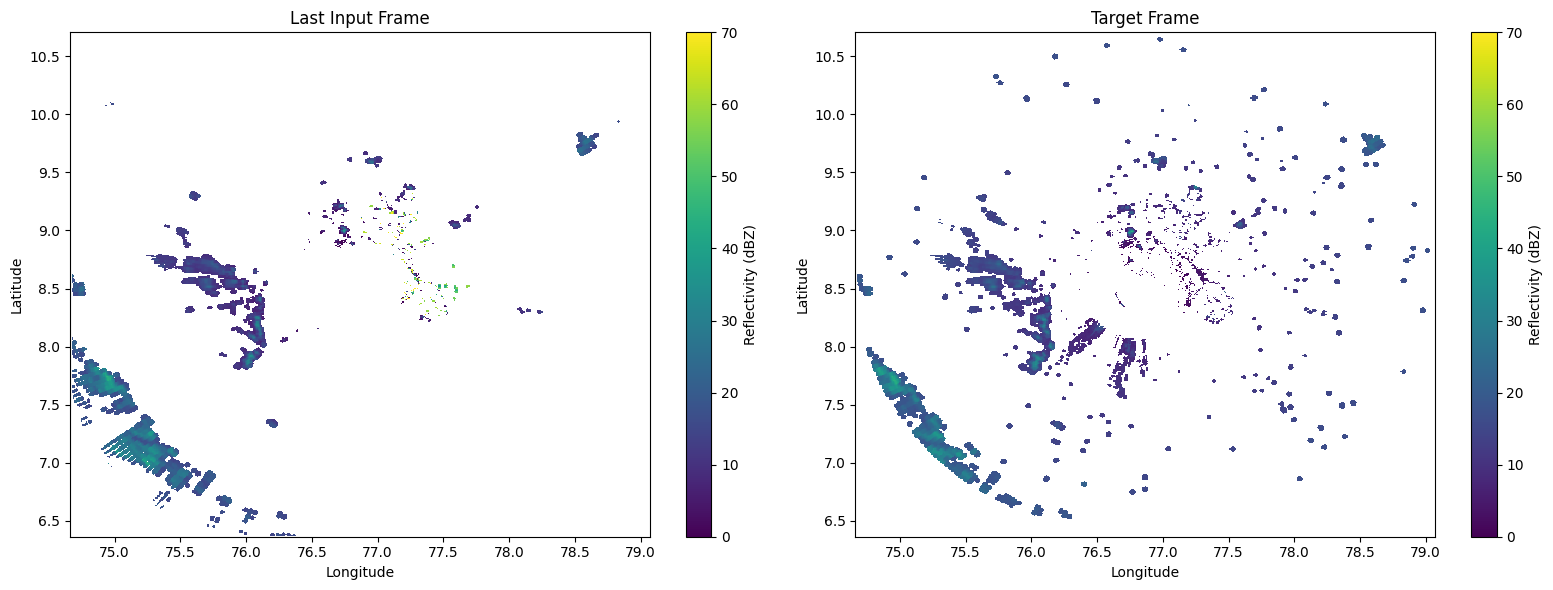

In [3]:
plot_sample(dataset[5])

(1, 481, 481) (481, 481) (481, 481)


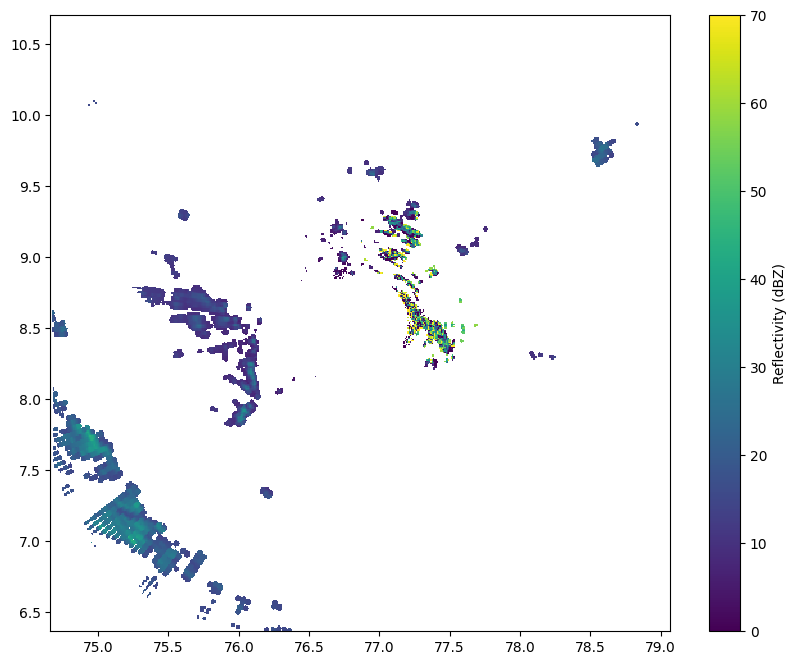

In [4]:
ds = xr.open_dataset(dataset.files[5])
plt.figure(figsize=(10, 8))
data = ds['DBZ'].clip(min=0, max=70)
print(ds['DBZ'].shape, ds['lon'].shape, ds['lat'].shape)
plt.pcolormesh(ds['lon'], ds["lat"], data[0], cmap='viridis', shading='auto')
plt.colorbar(label="Reflectivity (dBZ)")
plt.show()

In [11]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,  pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True)
print(f"Train size: {len(train_loader.dataset)}, Test size: {len(test_loader.dataset)}")
for out in train_loader:
    print(f"Input shape: {out["input"].shape}, Target shape: {out["target"].shape}")
    break

Train size: 18754, Test size: 4689
Input shape: torch.Size([8, 4, 512, 512]), Target shape: torch.Size([8, 1, 512, 512])


#### Model

In [12]:
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
import torch.nn as nn

In [13]:
## 19GB 
model = UNet2DModel(
    sample_size=512,  # the target image resolution
    in_channels=1 + window_size,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 32, 64, 64, 128, 128),    
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)
NUM_TRAIN_TIMESTEPS = 1000
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)
n_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda"
print("Using device:", device)
model = model.to(device)
torch.compile(model)
loss_fn = nn.MSELoss()
model.train()
print("Training model...")

# opt = torch.optim.Adam(model.parameters(), lr=5e-4)
# losses = []
# from tqdm import tqdm
# for epoch in range(n_epochs):
#     for out in tqdm(train_loader):
#         condition = out["input"].float()
#         target = out["target"].float()   
#         condition = condition.to(device) 
#         target = target.to(device)
        
#         noise = torch.randn_like(target)
#         timesteps = torch.randint(0, NUM_TRAIN_TIMESTEPS, (target.shape[0],)).long().to(device) # [B]
#         noisy_target_images = noise_scheduler.add_noise(target, noise, timesteps).to(device) # [B, 1, 512, 512]
#         model_input = torch.cat((noisy_target_images, condition), dim=1) #[B, 1+window_size, 512, 512]
#         pred = model(model_input, timesteps).sample # [B, 1, 512, 512]
#         loss = loss_fn(pred, noise)  # [B, 1, 512, 512] - [1, 1, 512, 512]
#         opt.zero_grad()
#         loss.backward()
#         opt.step()

#         losses.append(loss.item())
#     torch.save(model.state_dict(), f"diffusion_only_ddim{epoch}.pth")

#     avg_loss = sum(losses[-100:]) / 100
#     print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}")

Using device: cuda
Training model...


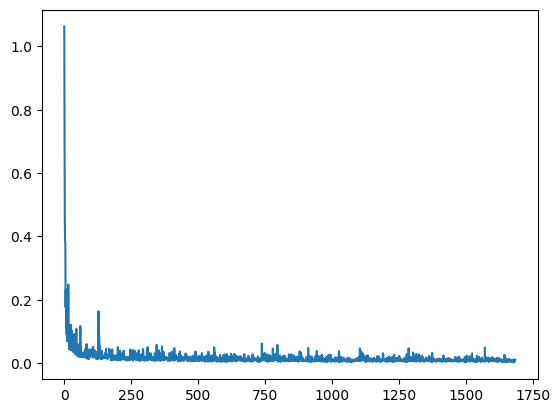

In [ ]:
plt.plot(losses)

**ddpm loss 0.03**

In [ ]:
def plot_sample(sample, vmin=0, vmax=70, label1="Last Input Frame", label2="Target Frame"):
    x = sample['input'][-1].numpy()
    y = sample['target'][0].numpy()
    lat = sample['lat'].numpy()
    lon = sample['lon'].numpy()
    H, W = lat.shape
    pad_h = x.shape[0] - H
    pad_w = x.shape[1] - W
    
    top = pad_h // 2
    left = pad_w // 2
    x_cropped = x[top:top+H, left:left+W]
    y_cropped = y[top:top+H, left:left+W]

    x_cropped = (x_cropped + 1.0) / 2.0
    y_cropped = (y_cropped + 1.0) / 2.0
    x_cropped = x_cropped * (70)
    y_cropped = y_cropped * (70)

    x_cropped[x_cropped <= 0] = np.nan
    # y_cropped[y_cropped <= 0] = np.nan

    plt.figure(figsize=(16, 6))
    
    plt.subplot(121)
    plt.pcolormesh(lon, lat, x_cropped, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(label="Reflectivity (dBZ)")
    plt.title(label1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.subplot(122)
    plt.pcolormesh(lon, lat, y_cropped, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(label="Reflectivity (dBZ)")
    plt.title(label2)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.tight_layout()
    plt.show()


In [9]:
model.load_state_dict(torch.load("diffusion_only_ddpm9.pth"))
model = model.to(device)

RuntimeError: Error(s) in loading state_dict for UNet2DModel:
	size mismatch for conv_in.weight: copying a param with shape torch.Size([32, 5, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 2, 3, 3]).
	size mismatch for conv_in.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for time_embedding.linear_1.weight: copying a param with shape torch.Size([128, 32]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for time_embedding.linear_1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for time_embedding.linear_2.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for time_embedding.linear_2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.0.resnets.0.norm1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.0.resnets.0.norm1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.0.resnets.0.conv1.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for down_blocks.0.resnets.0.conv1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.0.resnets.0.time_emb_proj.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for down_blocks.0.resnets.0.time_emb_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.0.resnets.0.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.0.resnets.0.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.0.resnets.0.conv2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for down_blocks.0.resnets.0.conv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.0.resnets.1.norm1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.0.resnets.1.norm1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.0.resnets.1.conv1.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for down_blocks.0.resnets.1.conv1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.0.resnets.1.time_emb_proj.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for down_blocks.0.resnets.1.time_emb_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.0.resnets.1.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.0.resnets.1.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.0.resnets.1.conv2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for down_blocks.0.resnets.1.conv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.0.downsamplers.0.conv.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for down_blocks.0.downsamplers.0.conv.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.resnets.0.norm1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.resnets.0.norm1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.resnets.0.conv1.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for down_blocks.1.resnets.0.conv1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.resnets.0.time_emb_proj.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for down_blocks.1.resnets.0.time_emb_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.resnets.0.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.resnets.0.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.resnets.0.conv2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for down_blocks.1.resnets.0.conv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.resnets.1.norm1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.resnets.1.norm1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.resnets.1.conv1.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for down_blocks.1.resnets.1.conv1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.resnets.1.time_emb_proj.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for down_blocks.1.resnets.1.time_emb_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.resnets.1.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.resnets.1.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.resnets.1.conv2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for down_blocks.1.resnets.1.conv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.1.downsamplers.0.conv.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for down_blocks.1.downsamplers.0.conv.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.2.resnets.0.norm1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.2.resnets.0.norm1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down_blocks.2.resnets.0.conv1.weight: copying a param with shape torch.Size([64, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for down_blocks.2.resnets.0.conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.2.resnets.0.time_emb_proj.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for down_blocks.2.resnets.0.time_emb_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.2.resnets.0.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.2.resnets.0.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.2.resnets.0.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for down_blocks.2.resnets.0.conv2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.2.resnets.0.conv_shortcut.weight: copying a param with shape torch.Size([64, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for down_blocks.2.resnets.0.conv_shortcut.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.2.resnets.1.norm1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.2.resnets.1.norm1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.2.resnets.1.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for down_blocks.2.resnets.1.conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.2.resnets.1.time_emb_proj.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for down_blocks.2.resnets.1.time_emb_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.2.resnets.1.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.2.resnets.1.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.2.resnets.1.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for down_blocks.2.resnets.1.conv2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.2.downsamplers.0.conv.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for down_blocks.2.downsamplers.0.conv.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.resnets.0.norm1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.resnets.0.norm1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.resnets.0.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for down_blocks.3.resnets.0.conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.resnets.0.time_emb_proj.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for down_blocks.3.resnets.0.time_emb_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.resnets.0.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.resnets.0.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.resnets.0.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for down_blocks.3.resnets.0.conv2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.resnets.1.norm1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.resnets.1.norm1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.resnets.1.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for down_blocks.3.resnets.1.conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.resnets.1.time_emb_proj.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for down_blocks.3.resnets.1.time_emb_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.resnets.1.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.resnets.1.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.resnets.1.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for down_blocks.3.resnets.1.conv2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.3.downsamplers.0.conv.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for down_blocks.3.downsamplers.0.conv.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.4.attentions.0.group_norm.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.attentions.0.group_norm.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.attentions.0.to_q.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for down_blocks.4.attentions.0.to_q.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.attentions.0.to_k.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for down_blocks.4.attentions.0.to_k.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.attentions.0.to_v.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for down_blocks.4.attentions.0.to_v.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.attentions.0.to_out.0.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for down_blocks.4.attentions.0.to_out.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.attentions.1.group_norm.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.attentions.1.group_norm.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.attentions.1.to_q.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for down_blocks.4.attentions.1.to_q.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.attentions.1.to_k.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for down_blocks.4.attentions.1.to_k.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.attentions.1.to_v.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for down_blocks.4.attentions.1.to_v.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.attentions.1.to_out.0.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for down_blocks.4.attentions.1.to_out.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.resnets.0.norm1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.4.resnets.0.norm1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down_blocks.4.resnets.0.conv1.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 3, 3]).
	size mismatch for down_blocks.4.resnets.0.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.resnets.0.time_emb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for down_blocks.4.resnets.0.time_emb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.resnets.0.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.resnets.0.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.resnets.0.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for down_blocks.4.resnets.0.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.resnets.0.conv_shortcut.weight: copying a param with shape torch.Size([128, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for down_blocks.4.resnets.0.conv_shortcut.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.resnets.1.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.resnets.1.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.resnets.1.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for down_blocks.4.resnets.1.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.resnets.1.time_emb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for down_blocks.4.resnets.1.time_emb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.resnets.1.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.resnets.1.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.resnets.1.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for down_blocks.4.resnets.1.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.4.downsamplers.0.conv.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for down_blocks.4.downsamplers.0.conv.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.5.resnets.0.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.5.resnets.0.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.5.resnets.0.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for down_blocks.5.resnets.0.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.5.resnets.0.time_emb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for down_blocks.5.resnets.0.time_emb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.5.resnets.0.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.5.resnets.0.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.5.resnets.0.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for down_blocks.5.resnets.0.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.5.resnets.1.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.5.resnets.1.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.5.resnets.1.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for down_blocks.5.resnets.1.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.5.resnets.1.time_emb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for down_blocks.5.resnets.1.time_emb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.5.resnets.1.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.5.resnets.1.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down_blocks.5.resnets.1.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for down_blocks.5.resnets.1.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.0.norm1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for up_blocks.0.resnets.0.norm1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for up_blocks.0.resnets.0.conv1.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1024, 3, 3]).
	size mismatch for up_blocks.0.resnets.0.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.0.time_emb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.0.resnets.0.time_emb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.0.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.0.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.0.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for up_blocks.0.resnets.0.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.0.conv_shortcut.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 1024, 1, 1]).
	size mismatch for up_blocks.0.resnets.0.conv_shortcut.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.1.norm1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for up_blocks.0.resnets.1.norm1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for up_blocks.0.resnets.1.conv1.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1024, 3, 3]).
	size mismatch for up_blocks.0.resnets.1.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.1.time_emb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.0.resnets.1.time_emb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.1.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.1.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.1.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for up_blocks.0.resnets.1.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.1.conv_shortcut.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 1024, 1, 1]).
	size mismatch for up_blocks.0.resnets.1.conv_shortcut.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.2.norm1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for up_blocks.0.resnets.2.norm1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for up_blocks.0.resnets.2.conv1.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1024, 3, 3]).
	size mismatch for up_blocks.0.resnets.2.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.2.time_emb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.0.resnets.2.time_emb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.2.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.2.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.2.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for up_blocks.0.resnets.2.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.resnets.2.conv_shortcut.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 1024, 1, 1]).
	size mismatch for up_blocks.0.resnets.2.conv_shortcut.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.0.upsamplers.0.conv.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for up_blocks.0.upsamplers.0.conv.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.0.group_norm.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.0.group_norm.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.0.to_q.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.attentions.0.to_q.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.0.to_k.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.attentions.0.to_k.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.0.to_v.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.attentions.0.to_v.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.0.to_out.0.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.attentions.0.to_out.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.1.group_norm.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.1.group_norm.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.1.to_q.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.attentions.1.to_q.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.1.to_k.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.attentions.1.to_k.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.1.to_v.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.attentions.1.to_v.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.1.to_out.0.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.attentions.1.to_out.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.2.group_norm.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.2.group_norm.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.2.to_q.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.attentions.2.to_q.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.2.to_k.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.attentions.2.to_k.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.2.to_v.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.attentions.2.to_v.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.attentions.2.to_out.0.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.attentions.2.to_out.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.0.norm1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for up_blocks.1.resnets.0.norm1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for up_blocks.1.resnets.0.conv1.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1024, 3, 3]).
	size mismatch for up_blocks.1.resnets.0.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.0.time_emb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.resnets.0.time_emb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.0.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.0.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.0.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for up_blocks.1.resnets.0.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.0.conv_shortcut.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 1024, 1, 1]).
	size mismatch for up_blocks.1.resnets.0.conv_shortcut.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.1.norm1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for up_blocks.1.resnets.1.norm1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for up_blocks.1.resnets.1.conv1.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1024, 3, 3]).
	size mismatch for up_blocks.1.resnets.1.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.1.time_emb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.resnets.1.time_emb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.1.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.1.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.1.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for up_blocks.1.resnets.1.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.1.conv_shortcut.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 1024, 1, 1]).
	size mismatch for up_blocks.1.resnets.1.conv_shortcut.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.2.norm1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for up_blocks.1.resnets.2.norm1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for up_blocks.1.resnets.2.conv1.weight: copying a param with shape torch.Size([128, 192, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 768, 3, 3]).
	size mismatch for up_blocks.1.resnets.2.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.2.time_emb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for up_blocks.1.resnets.2.time_emb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.2.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.2.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.2.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for up_blocks.1.resnets.2.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.resnets.2.conv_shortcut.weight: copying a param with shape torch.Size([128, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 768, 1, 1]).
	size mismatch for up_blocks.1.resnets.2.conv_shortcut.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.1.upsamplers.0.conv.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for up_blocks.1.upsamplers.0.conv.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.2.resnets.0.norm1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for up_blocks.2.resnets.0.norm1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for up_blocks.2.resnets.0.conv1.weight: copying a param with shape torch.Size([64, 192, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 768, 3, 3]).
	size mismatch for up_blocks.2.resnets.0.conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.0.time_emb_proj.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for up_blocks.2.resnets.0.time_emb_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.0.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.0.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.0.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for up_blocks.2.resnets.0.conv2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.0.conv_shortcut.weight: copying a param with shape torch.Size([64, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 768, 1, 1]).
	size mismatch for up_blocks.2.resnets.0.conv_shortcut.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.1.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.2.resnets.1.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.2.resnets.1.conv1.weight: copying a param with shape torch.Size([64, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 3, 3]).
	size mismatch for up_blocks.2.resnets.1.conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.1.time_emb_proj.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for up_blocks.2.resnets.1.time_emb_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.1.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.1.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.1.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for up_blocks.2.resnets.1.conv2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.1.conv_shortcut.weight: copying a param with shape torch.Size([64, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1]).
	size mismatch for up_blocks.2.resnets.1.conv_shortcut.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.2.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.2.resnets.2.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.2.resnets.2.conv1.weight: copying a param with shape torch.Size([64, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 3, 3]).
	size mismatch for up_blocks.2.resnets.2.conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.2.time_emb_proj.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for up_blocks.2.resnets.2.time_emb_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.2.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.2.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.2.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for up_blocks.2.resnets.2.conv2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.resnets.2.conv_shortcut.weight: copying a param with shape torch.Size([64, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1]).
	size mismatch for up_blocks.2.resnets.2.conv_shortcut.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.2.upsamplers.0.conv.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for up_blocks.2.upsamplers.0.conv.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.0.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.3.resnets.0.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.3.resnets.0.conv1.weight: copying a param with shape torch.Size([64, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 3, 3]).
	size mismatch for up_blocks.3.resnets.0.conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.0.time_emb_proj.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for up_blocks.3.resnets.0.time_emb_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.0.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.0.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.0.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for up_blocks.3.resnets.0.conv2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.0.conv_shortcut.weight: copying a param with shape torch.Size([64, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1]).
	size mismatch for up_blocks.3.resnets.0.conv_shortcut.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.1.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.3.resnets.1.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up_blocks.3.resnets.1.conv1.weight: copying a param with shape torch.Size([64, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 3, 3]).
	size mismatch for up_blocks.3.resnets.1.conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.1.time_emb_proj.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for up_blocks.3.resnets.1.time_emb_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.1.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.1.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.1.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for up_blocks.3.resnets.1.conv2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.1.conv_shortcut.weight: copying a param with shape torch.Size([64, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1]).
	size mismatch for up_blocks.3.resnets.1.conv_shortcut.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.2.norm1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for up_blocks.3.resnets.2.norm1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for up_blocks.3.resnets.2.conv1.weight: copying a param with shape torch.Size([64, 96, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 384, 3, 3]).
	size mismatch for up_blocks.3.resnets.2.conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.2.time_emb_proj.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for up_blocks.3.resnets.2.time_emb_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.2.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.2.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.2.conv2.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for up_blocks.3.resnets.2.conv2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.resnets.2.conv_shortcut.weight: copying a param with shape torch.Size([64, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 384, 1, 1]).
	size mismatch for up_blocks.3.resnets.2.conv_shortcut.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.3.upsamplers.0.conv.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for up_blocks.3.upsamplers.0.conv.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.4.resnets.0.norm1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for up_blocks.4.resnets.0.norm1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for up_blocks.4.resnets.0.conv1.weight: copying a param with shape torch.Size([32, 96, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 384, 3, 3]).
	size mismatch for up_blocks.4.resnets.0.conv1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.0.time_emb_proj.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for up_blocks.4.resnets.0.time_emb_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.0.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.0.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.0.conv2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for up_blocks.4.resnets.0.conv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.0.conv_shortcut.weight: copying a param with shape torch.Size([32, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 384, 1, 1]).
	size mismatch for up_blocks.4.resnets.0.conv_shortcut.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.1.norm1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.4.resnets.1.norm1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.4.resnets.1.conv1.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for up_blocks.4.resnets.1.conv1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.1.time_emb_proj.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for up_blocks.4.resnets.1.time_emb_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.1.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.1.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.1.conv2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for up_blocks.4.resnets.1.conv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.1.conv_shortcut.weight: copying a param with shape torch.Size([32, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1]).
	size mismatch for up_blocks.4.resnets.1.conv_shortcut.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.2.norm1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.4.resnets.2.norm1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.4.resnets.2.conv1.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for up_blocks.4.resnets.2.conv1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.2.time_emb_proj.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for up_blocks.4.resnets.2.time_emb_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.2.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.2.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.2.conv2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for up_blocks.4.resnets.2.conv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.resnets.2.conv_shortcut.weight: copying a param with shape torch.Size([32, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1]).
	size mismatch for up_blocks.4.resnets.2.conv_shortcut.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.4.upsamplers.0.conv.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for up_blocks.4.upsamplers.0.conv.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.0.norm1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.5.resnets.0.norm1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.5.resnets.0.conv1.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for up_blocks.5.resnets.0.conv1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.0.time_emb_proj.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for up_blocks.5.resnets.0.time_emb_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.0.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.0.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.0.conv2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for up_blocks.5.resnets.0.conv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.0.conv_shortcut.weight: copying a param with shape torch.Size([32, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1]).
	size mismatch for up_blocks.5.resnets.0.conv_shortcut.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.1.norm1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.5.resnets.1.norm1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.5.resnets.1.conv1.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for up_blocks.5.resnets.1.conv1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.1.time_emb_proj.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for up_blocks.5.resnets.1.time_emb_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.1.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.1.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.1.conv2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for up_blocks.5.resnets.1.conv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.1.conv_shortcut.weight: copying a param with shape torch.Size([32, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1]).
	size mismatch for up_blocks.5.resnets.1.conv_shortcut.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.2.norm1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.5.resnets.2.norm1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up_blocks.5.resnets.2.conv1.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for up_blocks.5.resnets.2.conv1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.2.time_emb_proj.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for up_blocks.5.resnets.2.time_emb_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.2.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.2.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.2.conv2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for up_blocks.5.resnets.2.conv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up_blocks.5.resnets.2.conv_shortcut.weight: copying a param with shape torch.Size([32, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1]).
	size mismatch for up_blocks.5.resnets.2.conv_shortcut.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for mid_block.attentions.0.group_norm.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.attentions.0.group_norm.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.attentions.0.to_q.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for mid_block.attentions.0.to_q.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.attentions.0.to_k.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for mid_block.attentions.0.to_k.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.attentions.0.to_v.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for mid_block.attentions.0.to_v.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.attentions.0.to_out.0.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for mid_block.attentions.0.to_out.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.resnets.0.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.resnets.0.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.resnets.0.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for mid_block.resnets.0.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.resnets.0.time_emb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for mid_block.resnets.0.time_emb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.resnets.0.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.resnets.0.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.resnets.0.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for mid_block.resnets.0.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.resnets.1.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.resnets.1.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.resnets.1.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for mid_block.resnets.1.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.resnets.1.time_emb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for mid_block.resnets.1.time_emb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.resnets.1.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.resnets.1.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mid_block.resnets.1.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for mid_block.resnets.1.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for conv_norm_out.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for conv_norm_out.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for conv_out.weight: copying a param with shape torch.Size([1, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 128, 3, 3]).

In [3]:
@torch.no_grad()
def generate_image(condition_images, model, noise_scheduler, device, num_inference_steps=50, guidance_scale=0.0):
    model.eval()
    if condition_images.ndim == 3:
        condition_images = condition_images.unsqueeze(0)
    condition_images = condition_images.to(device)

    target_shape = (condition_images.shape[0], 1, 512, 512)
    generated_images = torch.randn(target_shape, device=device)

    noise_scheduler.set_timesteps(num_inference_steps)

    for t in tqdm(noise_scheduler.timesteps, desc="Inference"):
        model_input = torch.cat((generated_images, condition_images), dim=1)
        noise_pred = model(model_input, t).sample

        generated_images = noise_scheduler.step(noise_pred, t, generated_images).prev_sample

    model.train()
    return generated_images

for test_data in test_loader: # Doing batch prediction
    condition_img_tensors = test_data["input"].to(device)
    true_target_img_tensors = test_data["target"].to(device)

    generated_outputs_batch = generate_image(condition_img_tensors, model, noise_scheduler, device, num_inference_steps=50)

    for i in range(generated_outputs_batch.shape[0]):
        single_condition_seq = condition_img_tensors[i].cpu() # [window_size, H, W]
        single_generated_output = generated_outputs_batch[i].cpu() # [1, H, W]
        single_true_target = true_target_img_tensors[i].cpu() # [1, H, W]

        plot_data = {
            'input': single_true_target,       
            'target': single_generated_output,   
            'lat': test_data['lat'][i].cpu(),  
            'lon': test_data['lon'][i].cpu()
        }
        plot_sample(plot_data, vmin=0, vmax=70, label1 = "truth", label2 = "generated")
    break

NameError: name 'test_loader' is not defined

Inference:  16%|█▌        | 16/100 [00:01<00:07, 11.05it/s]

Inference: 100%|██████████| 100/100 [00:09<00:00, 11.01it/s]


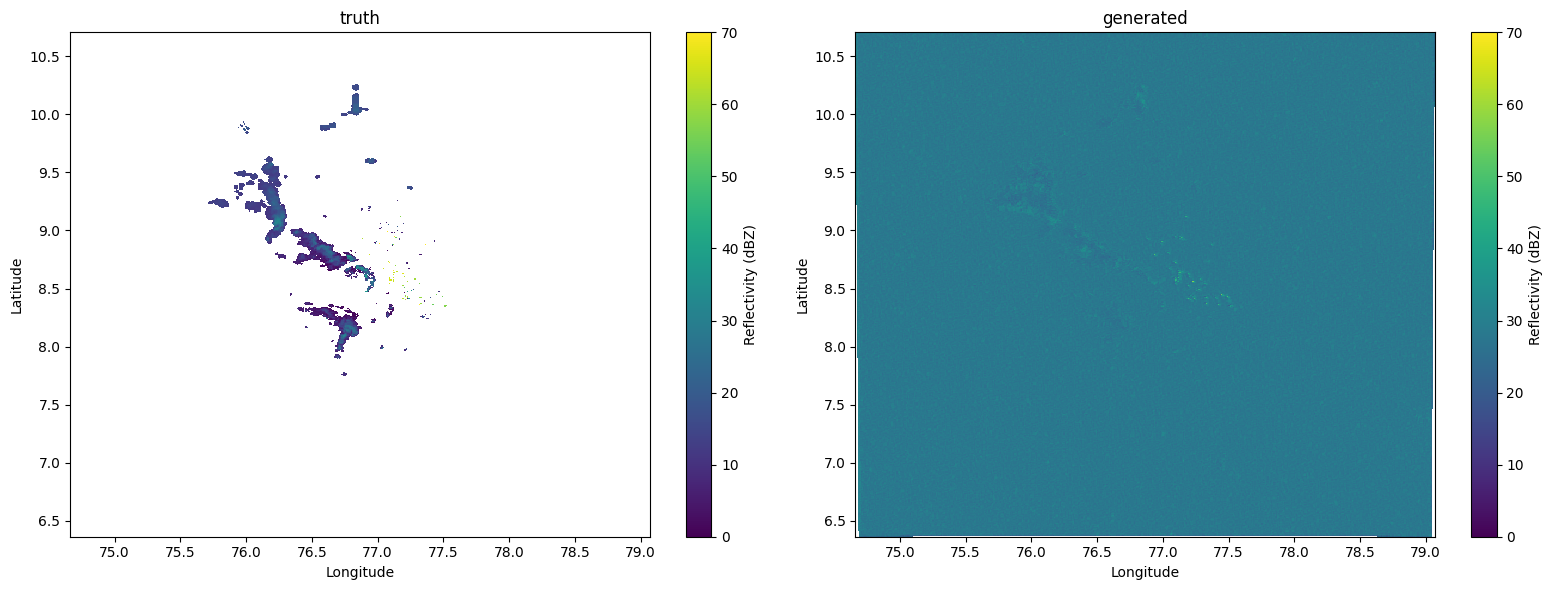

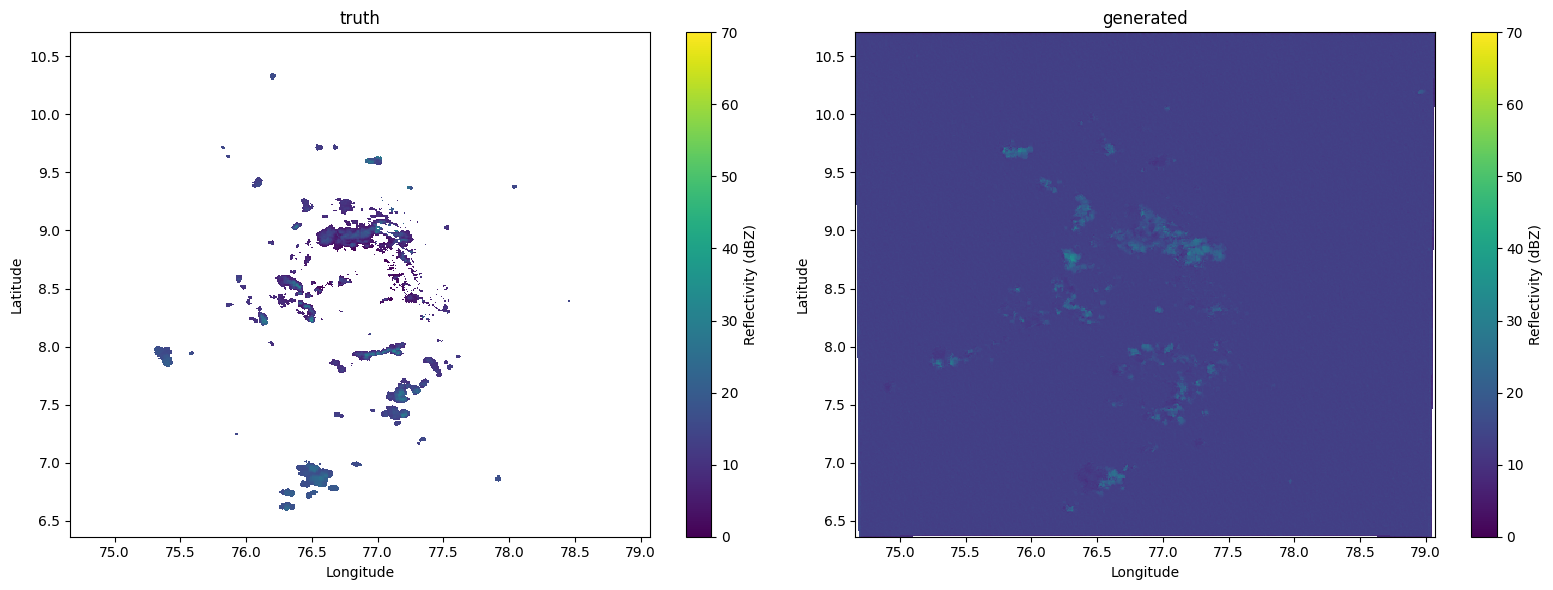

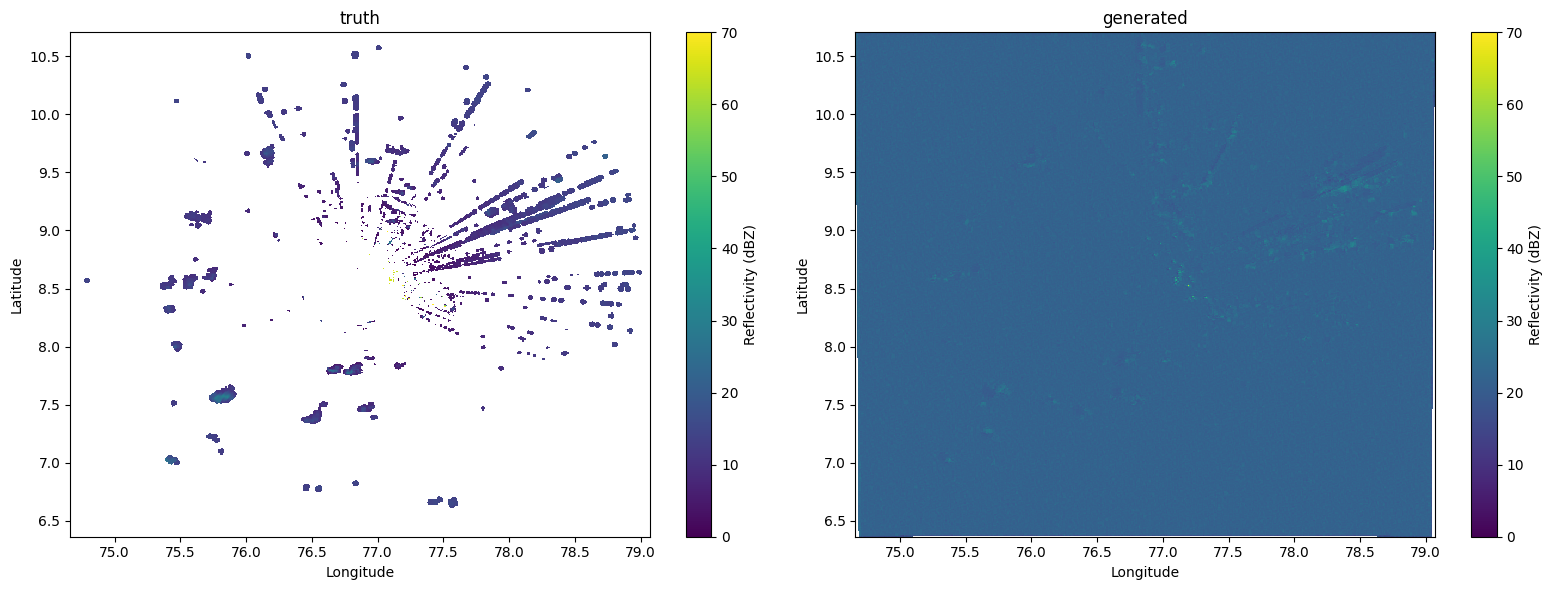

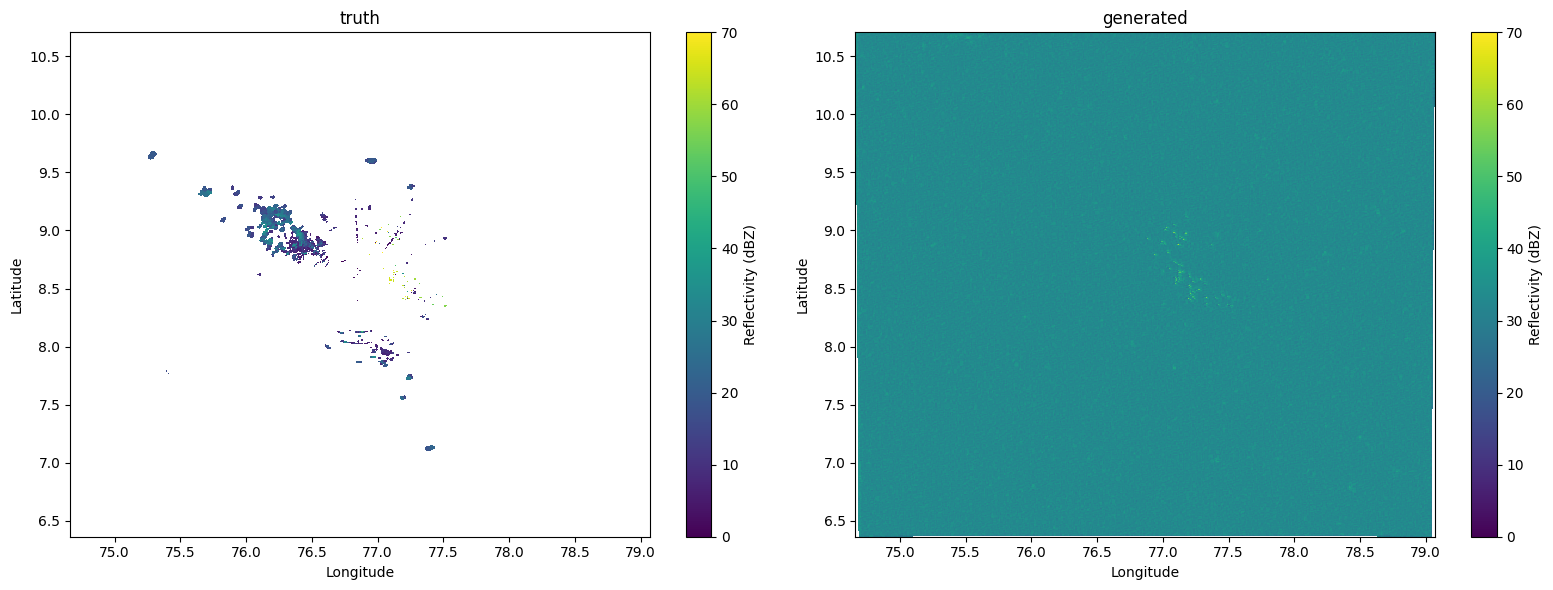

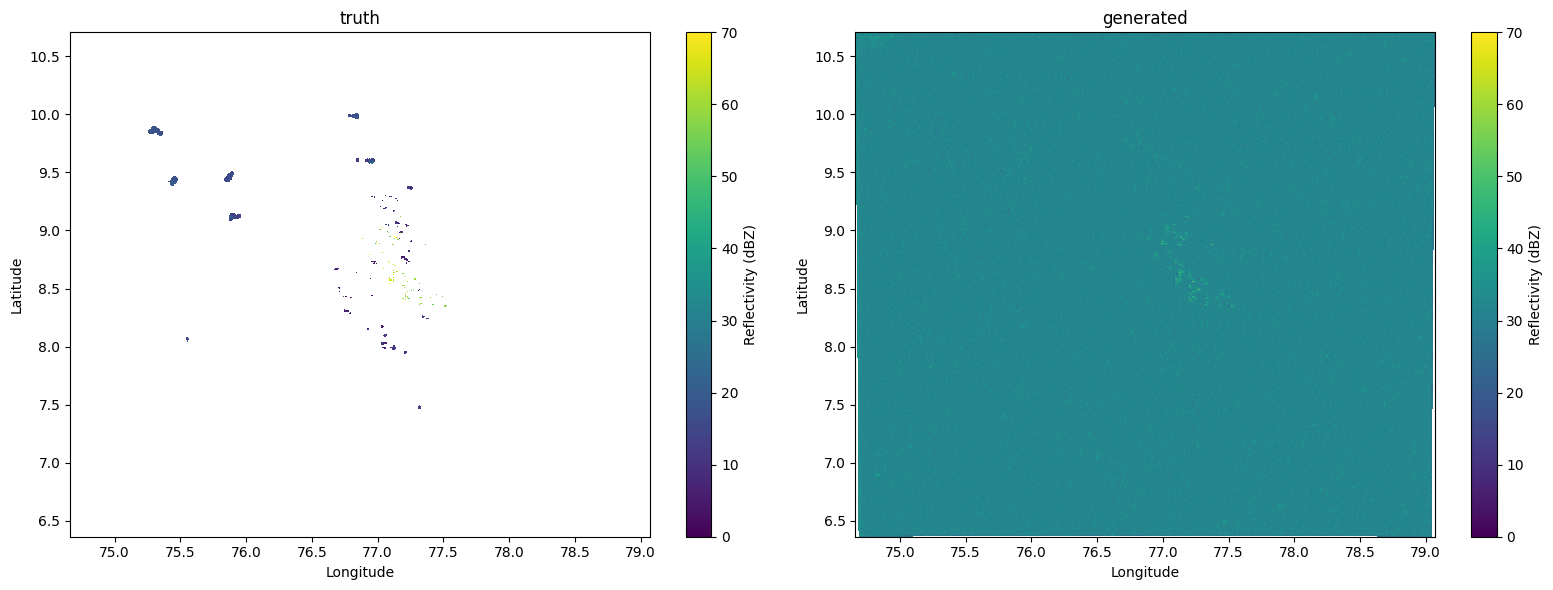

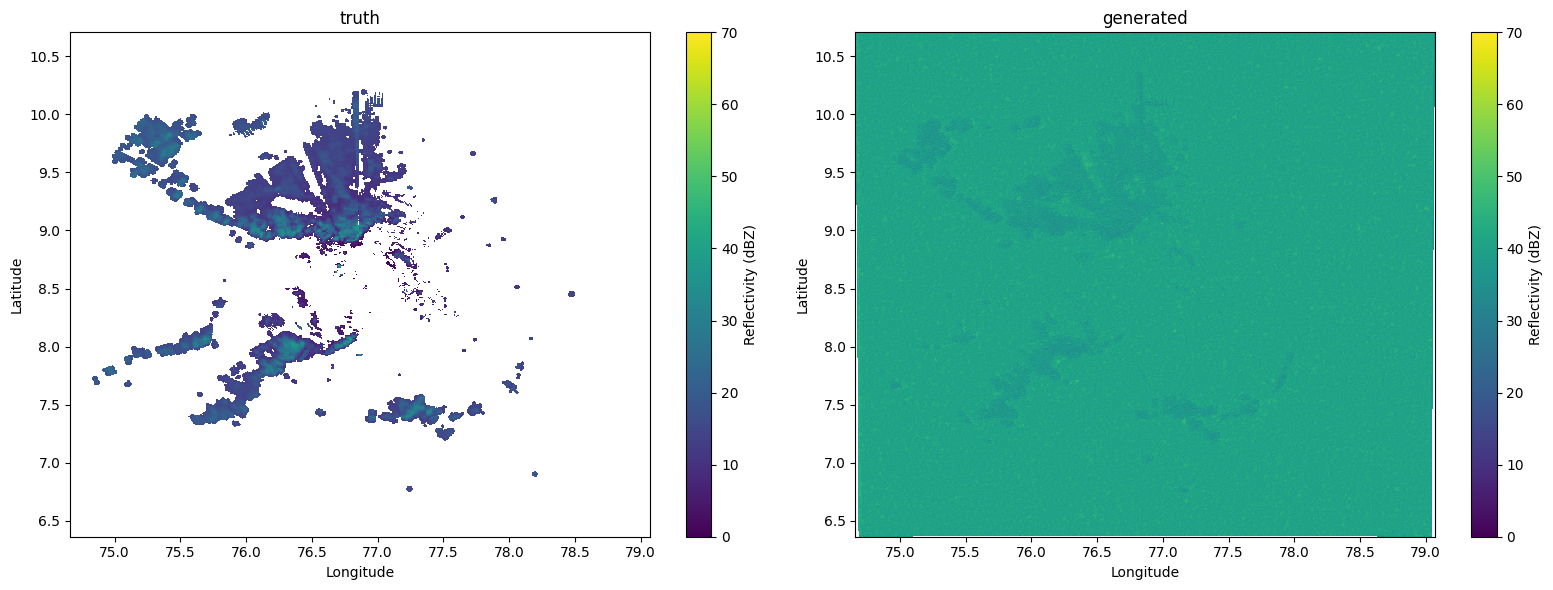

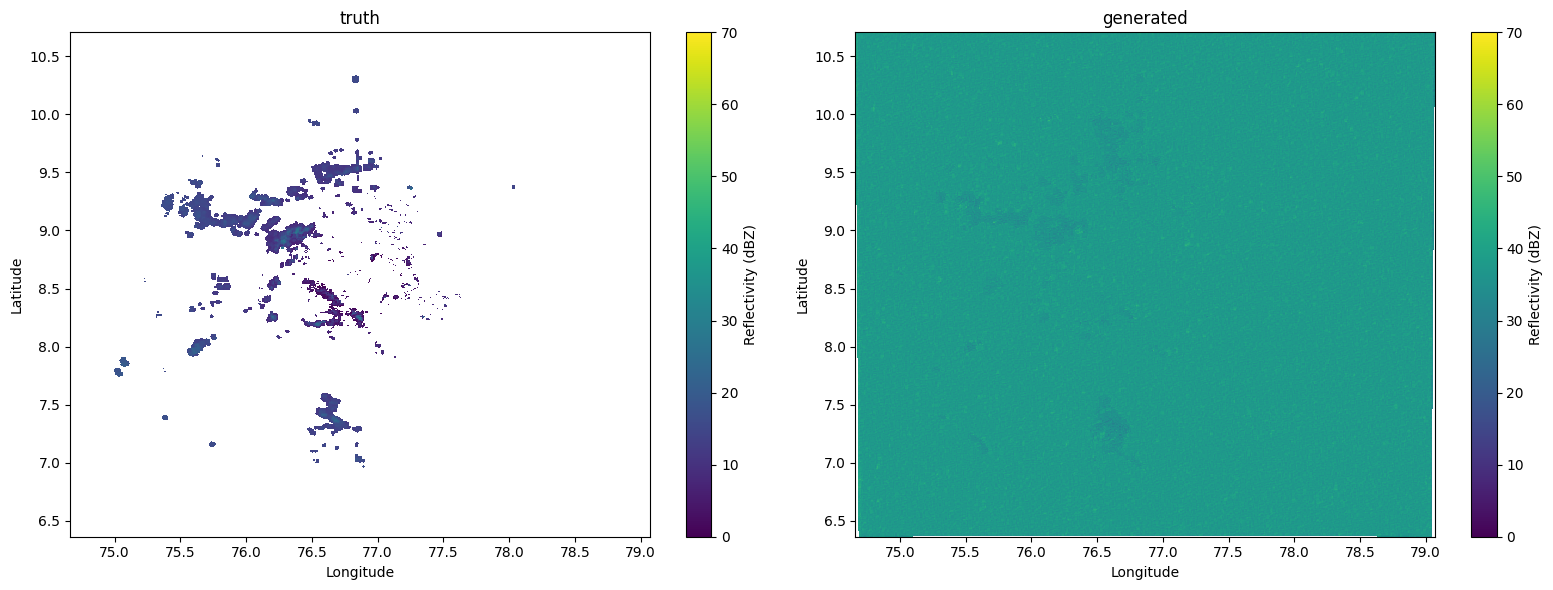

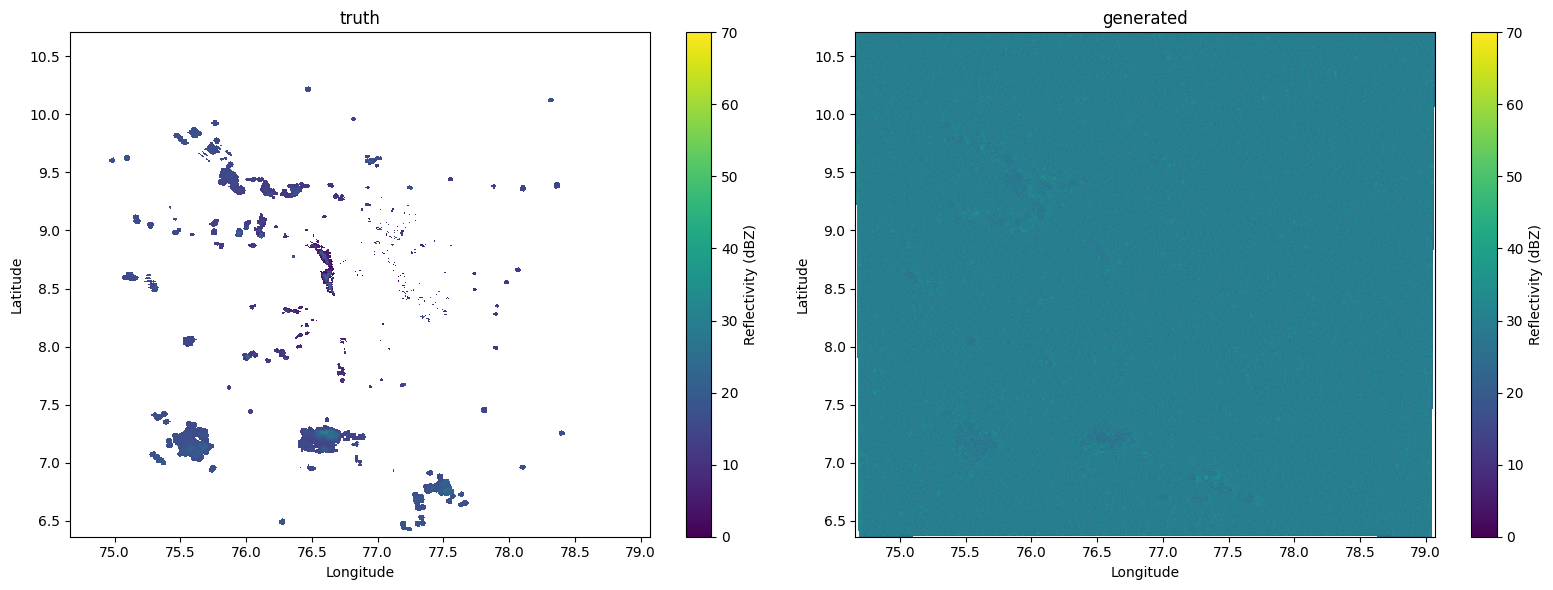

In [ ]:
DDPM